# 0.0 Imports

In [1]:
import pandas  as pd
import seaborn as sns
import numpy   as np
import matplotlib.pyplot as plt
import xgboost            as xgb

from sklearn                 import preprocessing    as pp
from sklearn.model_selection import train_test_split
from sklearn                 import metrics          as m
from sklearn                 import model_selection  as ms

from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn                 import svm
from lightgbm                import LGBMClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from imblearn.combine        import SMOTETomek


In [2]:
def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    accuracy_list = []
    f1_list = []
    mcc_list = []
    roc_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        # model precision
        precision = round(m.precision_score(y_val_fold, yhat_model),3)
        # recall
        recall = round(m.recall_score(y_val_fold, yhat_model),3)
        # model accuracy
        accuracy = round(m.accuracy_score(y_val_fold, yhat_model),3)
        # f1-score
        f1 = round(m.f1_score(y_val_fold, yhat_model),3)
        # mcc
        mcc = round(m.matthews_corrcoef(y_val_fold, yhat_model),3)
        #Roc_auc
        roc = round(m.roc_auc_score(y_val_fold,yhat_model),3)
        
        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        mcc_list.append(mcc)
        roc_list.append(roc)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    accuracy_str = np.round(np.mean(accuracy_list),4).astype(str) + ' +/- ' + np.round(np.std(accuracy_list),4).astype(str)
    f1_str = np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)    
    mcc_str = np.round(np.mean(mcc_list),4).astype(str) + ' +/- ' + np.round(np.std(mcc_list),4).astype(str)        
    auc_str = np.round(np.mean(roc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, accuracy_str, f1_str, mcc_str, auc_str], index=models_performance.columns), ignore_index=True)

    return models_performance

# 0.1 Loading Data

In [2]:
df = pd.read_csv('employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


# 1.0 About Dataset

1.0.1 Shape

In [4]:
print('Quantidade de linhas:', df.shape[0])
print('Quantidade de colunas:', df.shape[1])

Quantidade de linhas: 9540
Quantidade de colunas: 10


1.0.2 Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


1.0.3 Null values

In [6]:
df.isnull().sum()

department       0
promoted         0
review           0
projects         0
salary           0
tenure           0
satisfaction     0
bonus            0
avg_hrs_month    0
left             0
dtype: int64

1.0.4 Columns

In [7]:
df.columns

Index(['department', 'promoted', 'review', 'projects', 'salary', 'tenure',
       'satisfaction', 'bonus', 'avg_hrs_month', 'left'],
      dtype='object')

* Department - the department the employee belongs to.
* Promoted - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
* Review - the composite score the employee received in their last evaluation.
* Projects - how many projects the employee is involved in.
* Salary - for confidentiality reasons, salary comes in three tiers: low, medium, high.
* Tenure - how many years the employee has been at the company.
* Satisfaction - a measure of employee satisfaction from surveys.
* Bonus - 1 if the employee received a bonus in the previous 24 months, 0 otherwise.
* AvgHrsMonth - the average hours the employee worked in a month.
* Left - "yes" if the employee ended up leaving, "no" otherwise.

# 1.1 % people who left the company

In [8]:
df.left.value_counts(normalize=True)

no     0.708176
yes    0.291824
Name: left, dtype: float64

# 1.2 Split numerical, categorical e target attributes

In [9]:
numerical_attributes = df.drop(columns=['department','salary','left'])
categorical_attributes = df[['department','salary']]
target_attribute = df['left']


1.2.1 Describe about numerical attributes

In [10]:
numerical_attributes.describe()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


1.2.2 Categorical Attributes

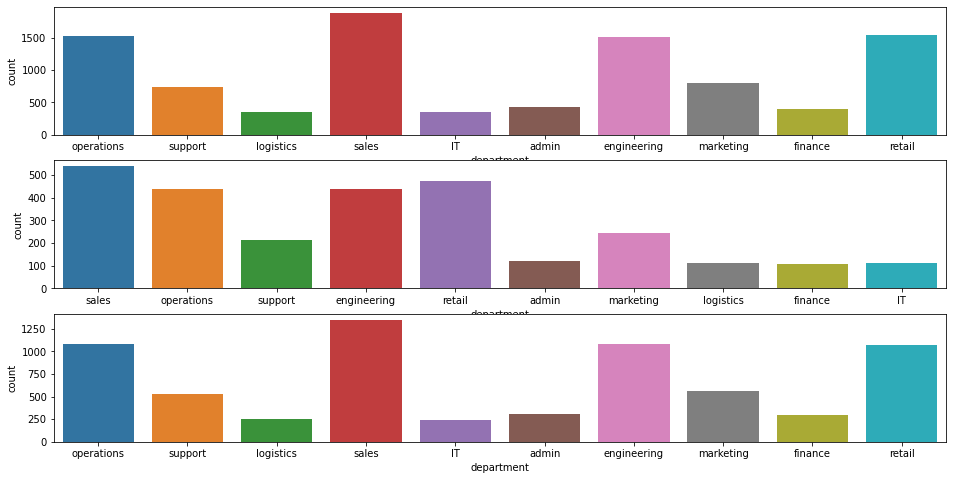

In [11]:
fig, axs = plt.subplots( nrows = 3,  figsize = (16,8))
sns.countplot(x='department', data= df, ax=axs[0])
sns.countplot(x='department', data= df[df['left']=='yes'], ax=axs[1])
sns.countplot(x='department',data=df[df['left']=='no'],ax=axs[2])

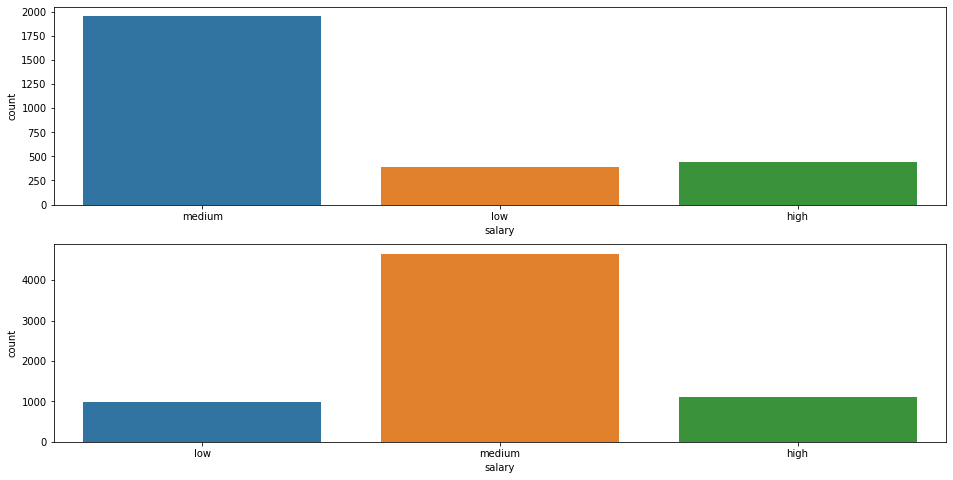

In [12]:
fig, axs = plt.subplots( nrows = 2,  figsize = (16,8))
sns.countplot(x='salary', data= df[df['left']=='yes'], ax=axs[0])
sns.countplot(x='salary',data=df[df['left']=='no'],ax=axs[1])

In [13]:
df[df.left=='yes'].salary.value_counts()

medium    1951
high       442
low        391
Name: salary, dtype: int64

In [14]:
df[df.left=='no'].salary.value_counts()

medium    4660
high      1106
low        990
Name: salary, dtype: int64

# 2.0 Hypotheses


*   Satisfaction from who left is smaller that who is in company
*   More than 90% of who left had between 5 and 8 years in the company
*   Most of those who left worked more than 184 hours per month (Higher than average)



# 3.0Exploratory Data Analysis

## 3.1 Univariate Analysis

## 3.1.1 Numerical analysis

In [15]:
numerical_attributes.columns

Index(['promoted', 'review', 'projects', 'tenure', 'satisfaction', 'bonus',
       'avg_hrs_month'],
      dtype='object')

**3.1.1.1 Promoted**

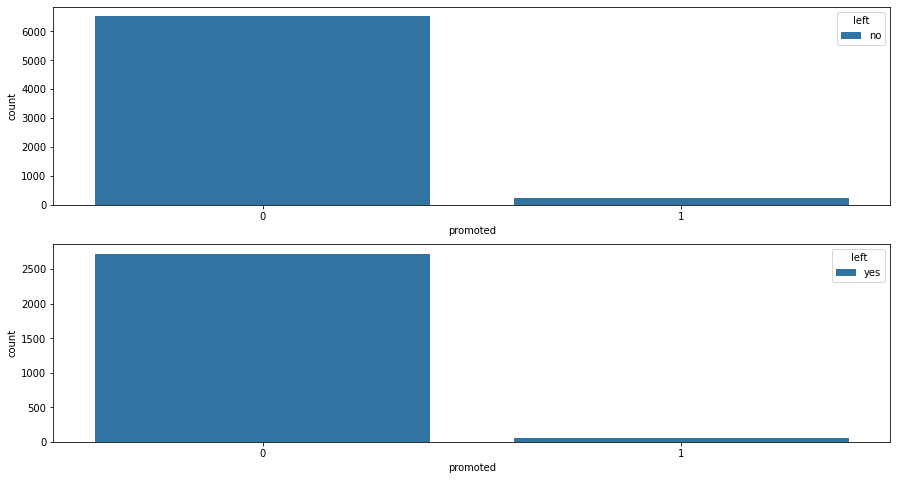

In [16]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'promoted', data=df[df['left']=='no'], hue='left',ax=axs[0]);
sns.countplot(x = 'promoted', data=df[df['left']=='yes'], hue='left',ax=axs[1]);

**3.1.1.2 Review**

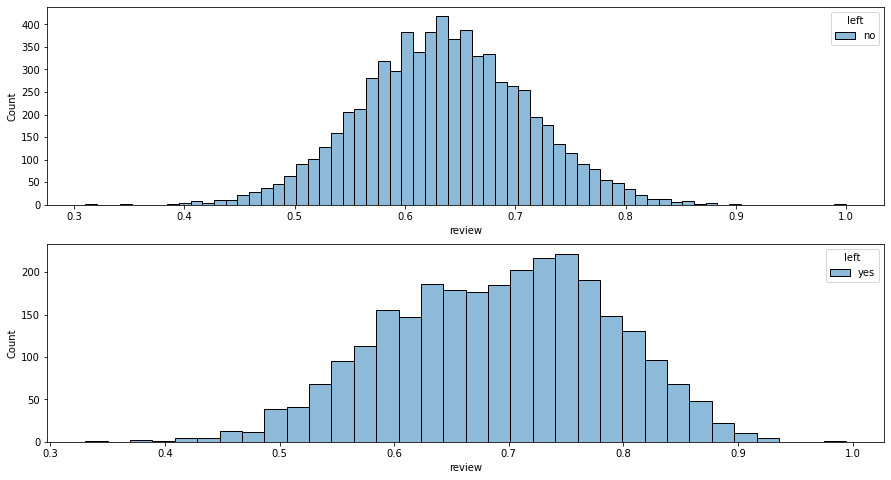

In [17]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.histplot(x = 'review', data=df[df['left']=='no'], hue='left',ax=axs[0]);
sns.histplot(x = 'review', data=df[df['left']=='yes'], hue='left',ax=axs[1]);

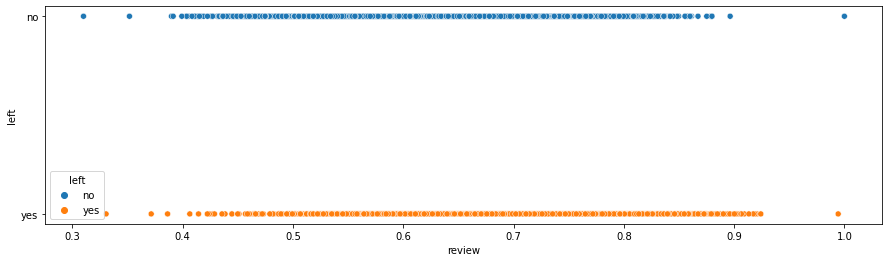

In [18]:
fig = plt.subplots( figsize = (15,4))
sns.scatterplot(x = 'review', data=df, y='left', hue = 'left');

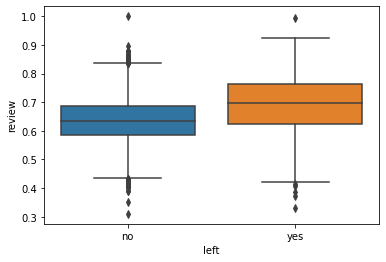

In [19]:
sns.boxplot(x= 'left', y='review', data=df);

**3.1.1.3 Projects**

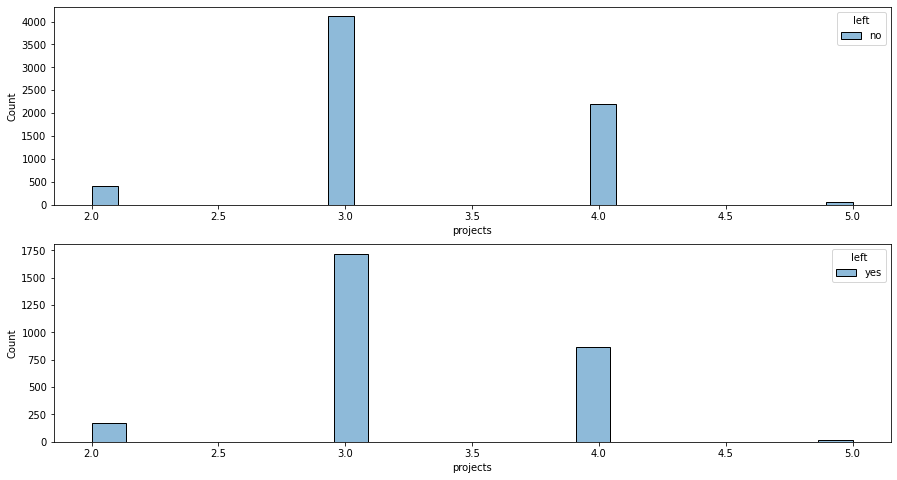

In [20]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.histplot(x = 'projects', data=df[df['left']=='no'], hue='left',ax=axs[0]);
sns.histplot(x = 'projects', data=df[df['left']=='yes'], hue='left',ax=axs[1]);

**3.1.1.4 Tenure**

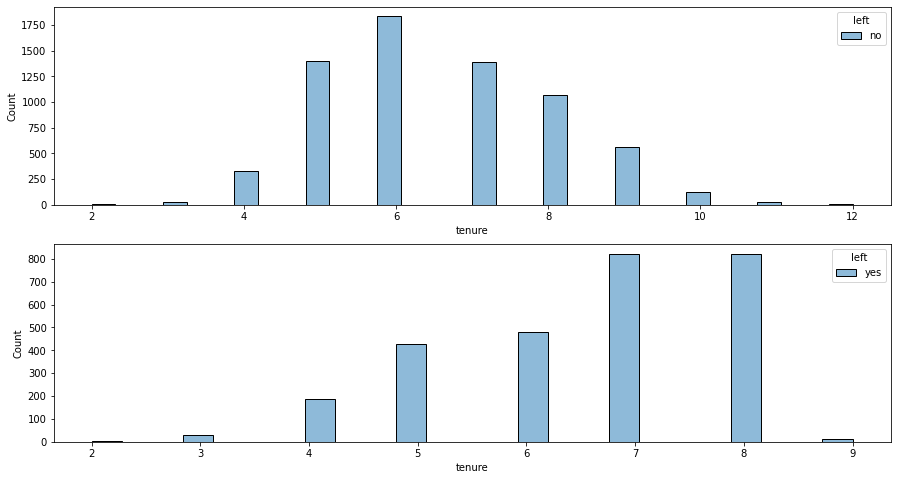

In [21]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.histplot(x = 'tenure', data=df[df['left']=='no'], hue='left',ax=axs[0]);
sns.histplot(x = 'tenure', data=df[df['left']=='yes'], hue='left',ax=axs[1]);

**3.1.1.5 Satisfaction**

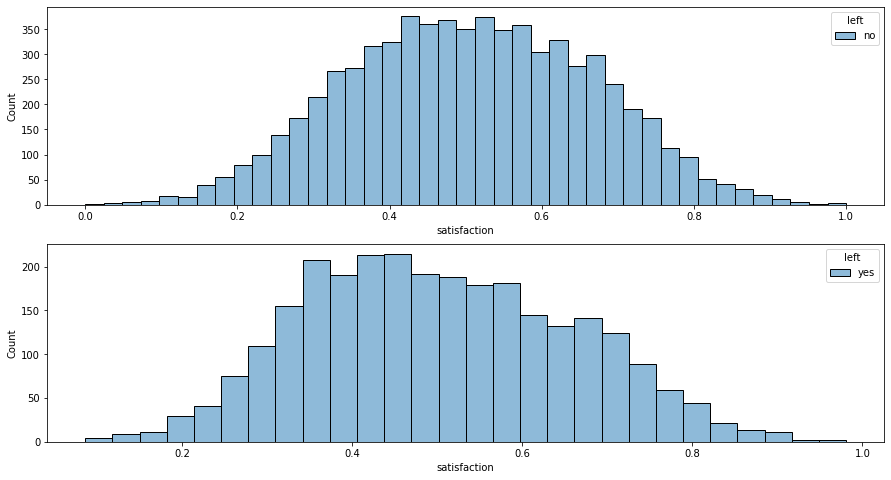

In [22]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.histplot(x = 'satisfaction', data=df[df['left']=='no'], hue='left',ax=axs[0]);
sns.histplot(x = 'satisfaction', data=df[df['left']=='yes'], hue='left',ax=axs[1]);

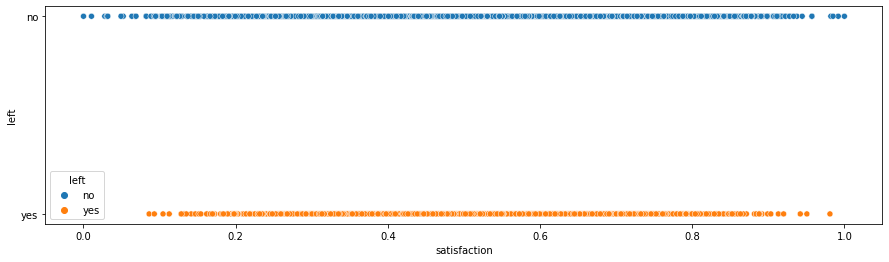

In [23]:
fig = plt.subplots( figsize = (15,4))
sns.scatterplot(x = 'satisfaction', data=df, y='left', hue = 'left');

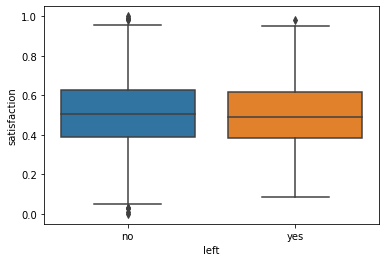

In [24]:
sns.boxplot(x= 'left', y='satisfaction', data=df);

**3.1.1.6 Bonus**

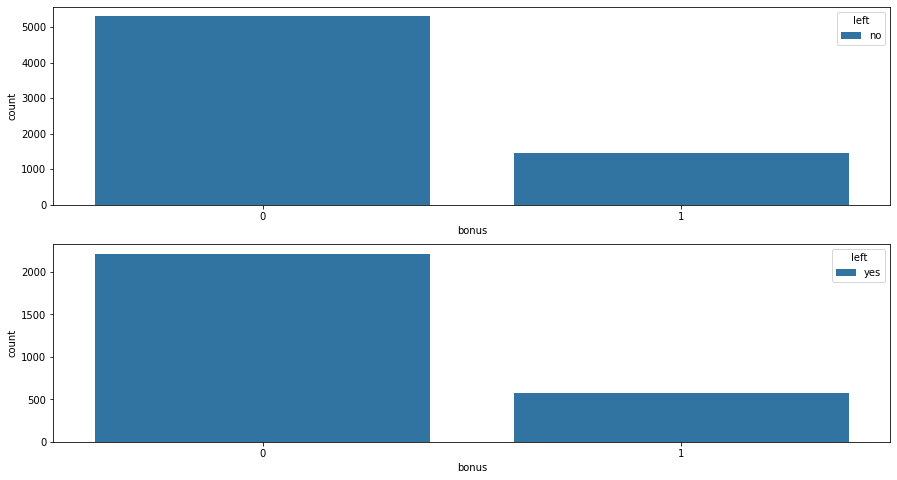

In [25]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'bonus', data=df[df['left']=='no'], hue='left',ax=axs[0]);
sns.countplot(x = 'bonus', data=df[df['left']=='yes'], hue='left',ax=axs[1]);

**3.1.1.7 Avg Hrs Month**

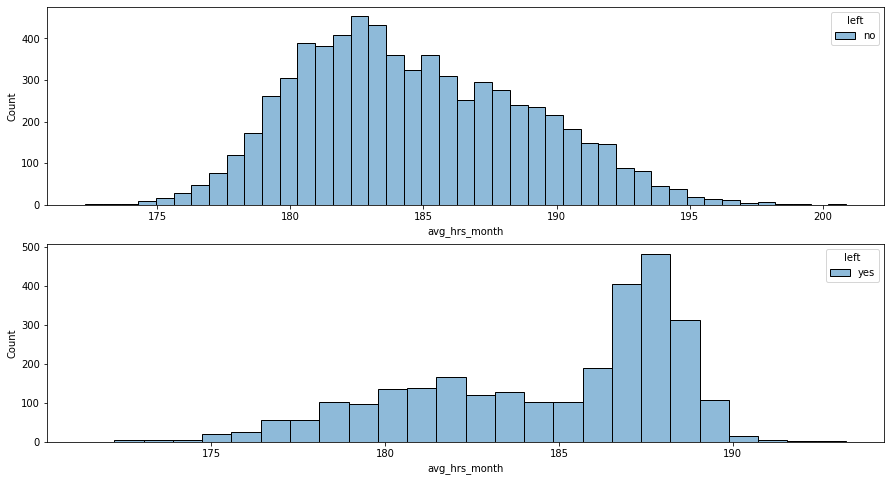

In [26]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.histplot(x = 'avg_hrs_month', data=df[df['left']=='no'], hue='left',ax=axs[0]);
sns.histplot(x = 'avg_hrs_month', data=df[df['left']=='yes'], hue='left',ax=axs[1]);

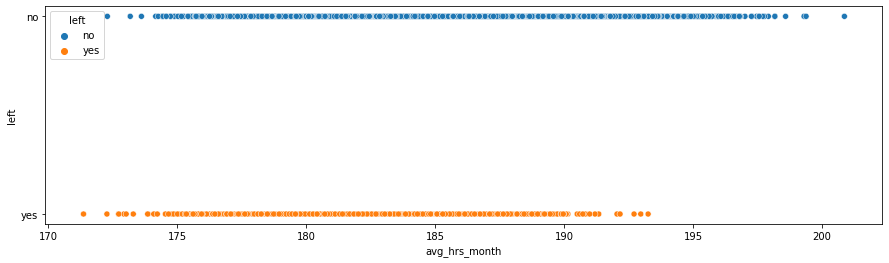

In [27]:
fig = plt.subplots( figsize = (15,4))
sns.scatterplot(x = 'avg_hrs_month', data=df, y='left', hue = 'left');

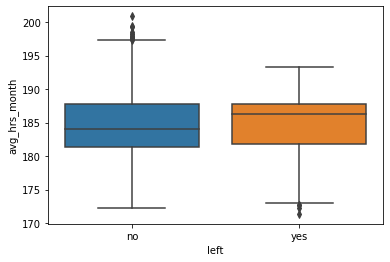

In [28]:
sns.boxplot(x= 'left', y='avg_hrs_month', data=df);

## 3.1.2 Categorical analysis

In [29]:
categorical_attributes.columns

Index(['department', 'salary'], dtype='object')

**3.1.2.1 Department**

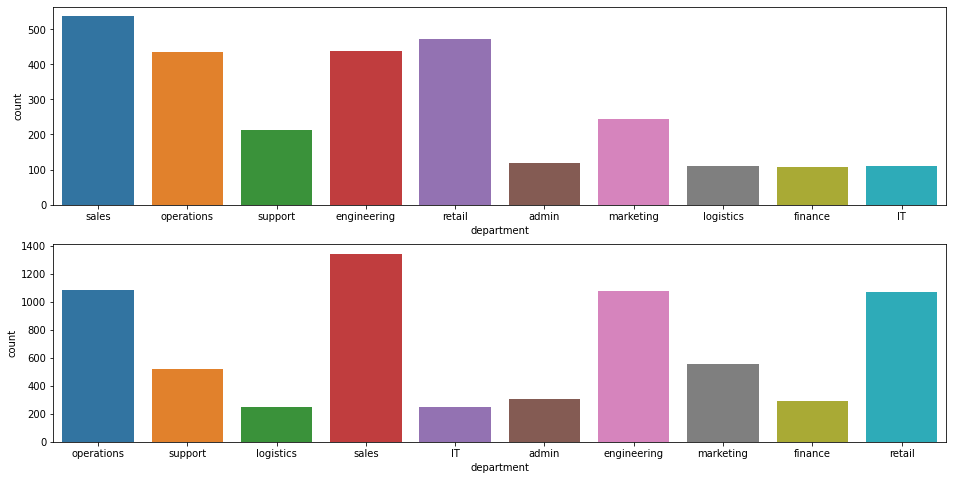

In [30]:
fig, axs = plt.subplots( nrows = 2,  figsize = (16,8))
sns.countplot(x='department', data= df[df['left']=='yes'], ax=axs[0])
sns.countplot(x='department',data=df[df['left']=='no'],ax=axs[1])

**3.1.2.2 Salary**

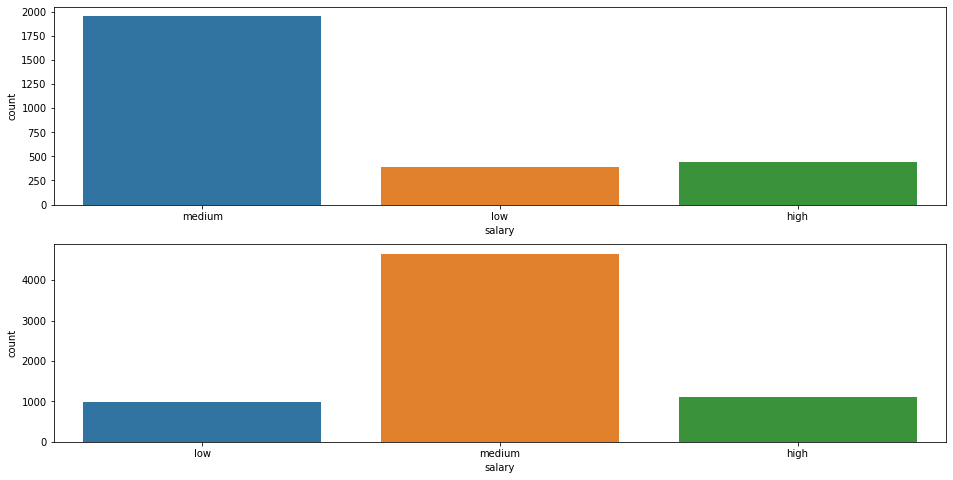

In [31]:
fig, axs = plt.subplots( nrows = 2,  figsize = (16,8))
sns.countplot(x='salary', data= df[df['left']=='yes'], ax=axs[0])
sns.countplot(x='salary',data=df[df['left']=='no'],ax=axs[1])

# 3.2 Bivariate Analysis

**3.2.1 Corr between 'review' and 'satisfaction'**

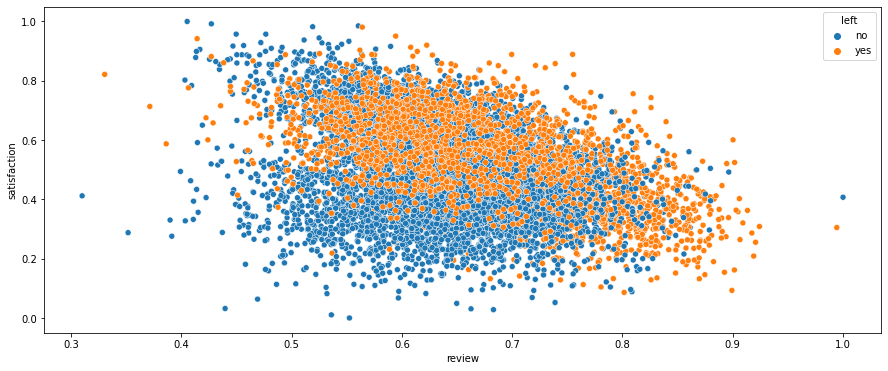

In [32]:
plt.subplots(figsize=(15,6))
sns.scatterplot(x='review', y='satisfaction',hue='left', data=df)

**3.2.2 More than 90% of who left had between 5 and 8 years in the company**

In [35]:
aux1.shape[0]

2784

In [36]:
aux3 = aux1[['tenure','left']]
aux3['left'] = aux3['left'].replace('yes',1)
aux3 = pd.crosstab(aux3['tenure'], aux3['left'])
aux3['percent %'] = aux3[1]*100/(aux1.shape[0])
aux3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


left,1,percent %
tenure,,
2.0,2,0.071839
3.0,30,1.077586
4.0,186,6.681034
5.0,428,15.373563
6.0,478,17.169540
7.0,823,29.561782
8.0,823,29.561782
9.0,14,0.502874


Hypothesis TRUE

* About 91,35% of the employees who left, worked for 5 until 8 years
* About 8,15% of the employees who left, worked for 4 years or less
* About 0,50% of the employees who left, worked for 9 years

**3.2.3 Most of those who left worked more than 184 hours per month (Higher than average)**

In [3]:
df[df['left']=='yes'].shape[0]

2784

In [9]:
aux4 = df[df['left']=='yes']
hy3 = aux4[aux4['avg_hrs_month']>184].shape[0]
print("Porcentagem de funcionários que sairam da empresa que trabalhavam acima de 184h mensais:", hy3*100/aux4.shape[0])

Porcentagem de funcionários que sairam da empresa que trabalhavam acima de 184h mensais: 61.997126436781606


Hypothesis TRUE

* About 61,99% of the employees who left, worked more than 184h per month. 184h is the average


**3.2.4 Mean of satisfaction per tenure from employees who left the company**

In [34]:
aux1 = df[df['left']=='yes']
aux1.groupby('tenure')['satisfaction'].mean()

tenure
2.0    0.573526
3.0    0.484267
4.0    0.439019
5.0    0.412456
6.0    0.385273
7.0    0.604135
8.0    0.533306
9.0    0.293466
Name: satisfaction, dtype: float64

**3.2.5 Mean of satisfaction per tenure from employees who didn't left the company**

In [37]:
aux2 = df[df['left']=='no']
relacao2 = aux2.groupby('tenure')['satisfaction'].mean()
relacao2

tenure
2.0     0.777297
3.0     0.703451
4.0     0.644517
5.0     0.602659
6.0     0.516628
7.0     0.408793
8.0     0.430604
9.0     0.495578
10.0    0.579281
11.0    0.634543
12.0    0.741743
Name: satisfaction, dtype: float64

**3.2.6 Corr between 'avg_hrs_month' and 'tenure'**

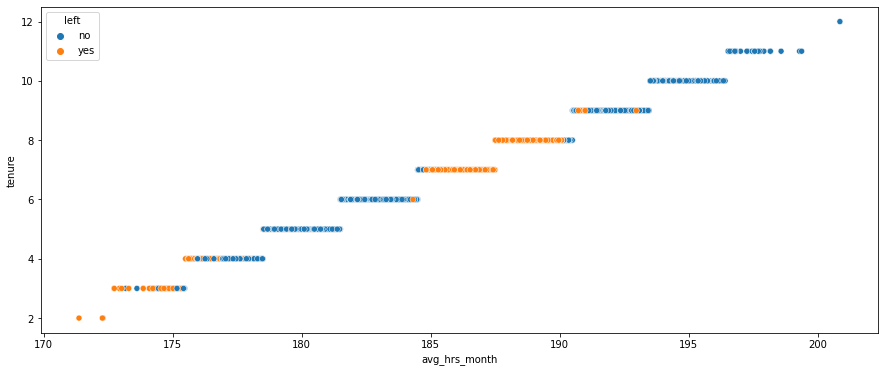

In [38]:
plt.subplots(figsize=(15,6))
sns.scatterplot(x='avg_hrs_month', y='tenure', hue='left', data=df)

**3.2.7 Corr between 'satisfaction' and 'tenure'**

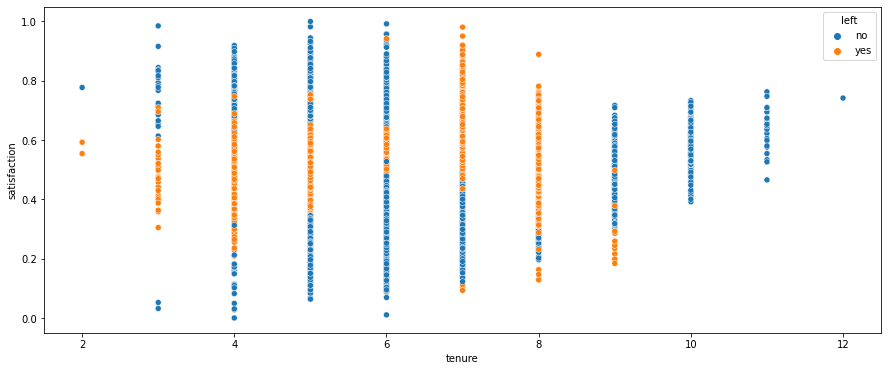

In [39]:
plt.subplots(figsize=(15,6))
sns.scatterplot(x='tenure', y='satisfaction', hue='left', data=df)

# 3.3 Multivariate Analysis

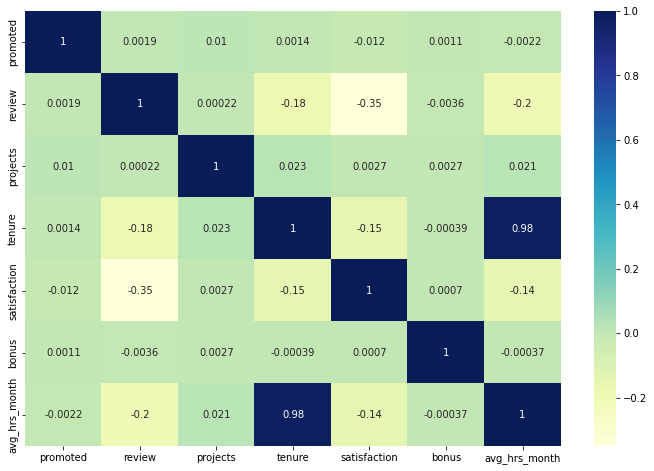

In [40]:
aux1 = df[df.left=='yes'] 
num_att = df.drop(columns=['department','salary','left'])
fig = plt.subplots(figsize = (12,8))
sns.heatmap(num_att.corr(), annot = True,cmap="YlGnBu");


# 4.0 Data preparation

In [85]:
df.columns

Index(['department', 'promoted', 'review', 'projects', 'salary', 'tenure',
       'satisfaction', 'bonus', 'avg_hrs_month', 'left'],
      dtype='object')

In [4]:
df2 = df.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

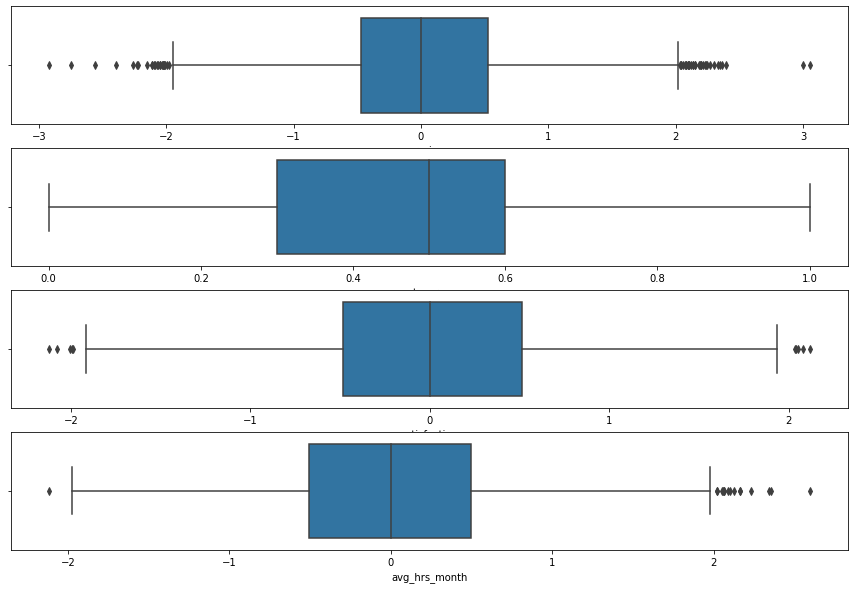

In [87]:
fig, axs = plt.subplots(nrows = 4, figsize = (15,10))
sns.boxplot(df['review'], ax=axs[0])
sns.boxplot(df['tenure'], ax=axs[1])
sns.boxplot(df['satisfaction'], ax=axs[2])
sns.boxplot(df['avg_hrs_month'], ax=axs[3])


## 4.1 Rescaling

In [5]:
#tenure
mms_tenure = pp.MinMaxScaler()
df2['tenure'] = mms_tenure.fit_transform(df2[['tenure']].values)

#review
rbs_review = pp.RobustScaler()
df2['review'] = rbs_review.fit_transform(df2[['review']].values)

#satisfaction
rbs_satisfaction = pp.RobustScaler()
df2['satisfaction'] = rbs_satisfaction.fit_transform(df2[['satisfaction']].values)

#Avg Hrs Month
rbs_avg = pp.RobustScaler()
df2['avg_hrs_month'] = rbs_avg.fit_transform(df2[['avg_hrs_month']].values)


## 4.2 Transformation - Encoding

In [6]:
#department
df2 = pd.get_dummies(df2, prefix=['depart'], columns=['department'])

#Projects
df2 = pd.get_dummies(df2, prefix=['prjt'], columns=['projects'])

#department
df2 = pd.get_dummies(df2, prefix=['sal'], columns=['salary'])


In [7]:
#Left
df2['left'][df2['left']=='no'] = df2['left'].replace('no',0)
df2['left'][df2['left']=='yes'] = df2['left'].replace('yes',1)
df2['left'] = df2['left'].astype(int)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
df2.head()

,promoted,review,tenure,satisfaction,bonus,avg_hrs_month,left,depart_IT,depart_admin,depart_engineering,...,depart_retail,depart_sales,depart_support,prjt_2,prjt_3,prjt_4,prjt_5,sal_high,sal_low,sal_medium
0,0,-0.605115,0.3,0.534226,0,-0.601399,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0.904312,0.4,-0.242177,0,-0.306978,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0.650177,0.4,-0.228843,0,-0.033998,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
3,0,0.239855,0.6,-0.257190,0,0.651909,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0.248902,0.3,0.325785,1,-0.768420,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [67]:
df2.iloc[1]

promoted              0.000000
review                0.904312
tenure                0.400000
satisfaction         -0.242177
bonus                 0.000000
avg_hrs_month        -0.306978
left                  0.000000
depart_admin          0.000000
depart_engineering    0.000000
depart_finance        0.000000
depart_logistics      0.000000
depart_marketing      0.000000
depart_operations     1.000000
depart_retail         0.000000
depart_sales          0.000000
depart_support        0.000000
prjt_3                1.000000
prjt_4                0.000000
prjt_5                0.000000
sal_low               0.000000
sal_medium            1.000000
Name: 1, dtype: float64

# 5.0 Train Preparation

## 5.1 Split Features and target

In [8]:
X = df2.drop('left',axis=1)
y = df2['left'].copy()


## 5.2 Train

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# 5.3 Balancing

In [11]:
print('Number of Rows: {}'.format(X_train.shape[0]))

Number of Rows: 5724


In [12]:
y_train.value_counts()

0    4048
1    1676
Name: left, dtype: int64

In [14]:
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# transforms the data set
X_balanced, y_balanced = resampler.fit_resample(X_train, y_train)

In [15]:
print('Number of Rows: {}'.format(X_balanced.shape[0]))

Number of Rows: 7716


In [16]:
y_balanced.value_counts()

1    3858
0    3858
Name: left, dtype: int64

In [17]:
X_train = X_balanced.copy()
y_train = y_balanced.copy()

# 6.0 Machine Learning Models

## 6.1 Logistic Regression Model

In [18]:
logreg_model = LogisticRegression(penalty='l2', solver='newton-cg')
model_reglog = logreg_model.fit(X_train,y_train)
yhat_reglog = model_reglog.predict(X_test)

In [19]:
# model precision
precision_logreg = round(m.precision_score(y_test, yhat_reglog),3)
# recall
recall_logreg = round(m.recall_score(y_test, yhat_reglog),3)
# model accuracy
accuracy_logreg = round(m.accuracy_score(y_test, yhat_reglog),3)
# f1-score
f1_logreg = round(m.f1_score(y_test, yhat_reglog),3)
# mcc
mcc_logreg = round(m.matthews_corrcoef(y_test, yhat_reglog),3)
#Roc_auc
roc_logreg = round(m.roc_auc_score(y_test,yhat_reglog),3)

print("precision: {}" .format(precision_logreg))
print("recall: {}" .format(recall_logreg))
print("accuracy {}".format(accuracy_logreg))
print("f1 {}".format(f1_logreg))
print("mcc {}".format(mcc_logreg))
print("roc {}".format(roc_logreg))

precision: 0.447
recall: 0.673
accuracy 0.663
f1 0.537
mcc 0.304
roc 0.666


In [20]:
m.confusion_matrix(y_test, yhat_reglog)

array([[1785,  923],
       [ 362,  746]])

In [21]:
models_performance = pd.DataFrame({'Model':['Logistic Regression'], "Precision": [precision_logreg], "Recall": [recall_logreg], "Accuracy": [accuracy_logreg], "F1_Score": [f1_logreg],"Matthews_CorrCoef": [mcc_logreg],"ROC_AUC_Score":[roc_logreg]})

## 6.2 K Neighbors Classifier model

In [22]:
knn_model = KNeighborsClassifier(n_jobs=-1,n_neighbors = 7)
model_knn = knn_model.fit(X_train,y_train)
yhat_knn = model_knn.predict(X_test)

In [23]:
precision_knn = round(m.precision_score(y_test, yhat_knn),3)
# recall
recall_knn = round(m.recall_score(y_test, yhat_knn),3)
# model accuracy
accuracy_knn = round(m.accuracy_score(y_test, yhat_knn),3)
# f1-score
f1_knn = round(m.f1_score(y_test, yhat_knn),3)
# mcc
mcc_knn = round(m.matthews_corrcoef(y_test, yhat_knn),3)
#Roc_auc
roc_knn = round(m.roc_auc_score(y_test,yhat_knn),3)

print("precision: {}" .format(precision_knn))
print("recall: {}" .format(recall_knn))
print("accuracy {}".format(accuracy_knn))
print("f1 {}".format(f1_knn))
print("mcc {}".format(mcc_knn))
print("roc {}".format(roc_knn))

precision: 0.53
recall: 0.762
accuracy 0.735
f1 0.625
mcc 0.447
roc 0.743


In [24]:
m.confusion_matrix(y_test, yhat_knn)

array([[1959,  749],
       [ 264,  844]])

In [25]:
models_performance = models_performance.append(pd.Series(['K Neighbors Classifier', precision_knn, recall_knn, accuracy_knn, f1_knn, mcc_knn, roc_knn],index=models_performance.columns), ignore_index=True)

## 6.3 Random Forest Classifier model

In [26]:
rfc_model = RandomForestClassifier(random_state=42)
model_rfc = rfc_model.fit(X_train,y_train)
yhat_rfc = model_rfc.predict(X_test)

In [27]:
# model precision
precision_rfc = round(m.precision_score(y_test, yhat_rfc),3)
# recall
recall_rfc = round(m.recall_score(y_test, yhat_rfc),3)
# model accuracy
accuracy_rfc = round(m.accuracy_score(y_test, yhat_rfc),3)
# f1-score
f1_rfc = round(m.f1_score(y_test, yhat_rfc),3)
# mcc
mcc_rfc = round(m.matthews_corrcoef(y_test, yhat_rfc),3)
#Roc_auc
roc_rfc = round(m.roc_auc_score(y_test,yhat_rfc),3)

print("precision: {}" .format(precision_rfc))
print("recall: {}" .format(recall_rfc))
print("accuracy {}".format(accuracy_rfc))
print("f1 {}".format(f1_rfc))
print("mcc {}".format(mcc_rfc))
print("roc {}".format(roc_rfc))

precision: 0.735
recall: 0.777
accuracy 0.854
f1 0.756
mcc 0.652
roc 0.831


In [28]:
m.confusion_matrix(y_test, yhat_rfc)

array([[2398,  310],
       [ 247,  861]])

In [29]:
models_performance = models_performance.append(pd.Series(['Random Forest Classifier', precision_rfc, recall_rfc, accuracy_rfc, f1_rfc, mcc_rfc, roc_rfc],index=models_performance.columns), ignore_index=True)

## 6.4 Naive Bayes Classifier model

In [30]:
nbc_model = GaussianNB()
model_nbc = nbc_model.fit(X_train,y_train)
yhat_nbc = model_nbc.predict(X_test)

In [31]:
# model precision
precision_nbc = round(m.precision_score(y_test, yhat_nbc),3)
# recall
recall_nbc = round(m.recall_score(y_test, yhat_nbc),3)
# model accuracy
accuracy_nbc = round(m.accuracy_score(y_test, yhat_nbc),3)
# f1-score
f1_nbc = round(m.f1_score(y_test, yhat_nbc),3)
# mcc
mcc_nbc = round(m.matthews_corrcoef(y_test, yhat_nbc),3)
#Roc_auc
roc_nbc = round(m.roc_auc_score(y_test,yhat_nbc),3)

print("precision: {}" .format(precision_nbc))
print("recall: {}" .format(recall_nbc))
print("accuracy {}".format(accuracy_nbc))
print("f1 {}".format(f1_nbc))
print("mcc {}".format(mcc_nbc))
print("roc {}".format(roc_nbc))

precision: 0.31
recall: 0.848
accuracy 0.407
f1 0.454
mcc 0.084
roc 0.537


In [32]:
m.confusion_matrix(y_test, yhat_nbc)

array([[ 613, 2095],
       [ 168,  940]])

In [33]:
models_performance = models_performance.append(pd.Series(['Naive Bayes Classifier', precision_nbc, recall_nbc, accuracy_nbc, f1_nbc, mcc_nbc, roc_nbc],index=models_performance.columns), ignore_index=True)

## 6.5 Light Gradient Boosting Machine Classifier model

In [34]:
lgbm_model = LGBMClassifier()
model_lgbm = lgbm_model.fit(X_train,y_train)
yhat_lgbm = model_lgbm.predict(X_test)

In [35]:
# model precision
precision_lgbm = round(m.precision_score(y_test, yhat_lgbm),3)
# recall
recall_lgbm = round(m.recall_score(y_test, yhat_lgbm),3)
# model accuracy
accuracy_lgbm = round(m.accuracy_score(y_test, yhat_lgbm),3)
# f1-score
f1_lgbm = round(m.f1_score(y_test, yhat_lgbm),3)
# mcc
mcc_lgbm = round(m.matthews_corrcoef(y_test, yhat_lgbm),3)
#Roc_auc
roc_lgbm = round(m.roc_auc_score(y_test,yhat_lgbm),3)

print("precision: {}" .format(precision_lgbm))
print("recall: {}" .format(recall_lgbm))
print("accuracy {}".format(accuracy_lgbm))
print("f1 {}".format(f1_lgbm))
print("mcc {}".format(mcc_lgbm))
print("roc {}".format(roc_lgbm))

precision: 0.751
recall: 0.816
accuracy 0.868
f1 0.782
mcc 0.689
roc 0.853


In [36]:
m.confusion_matrix(y_test, yhat_lgbm)

array([[2408,  300],
       [ 204,  904]])

In [37]:
models_performance = models_performance.append(pd.Series(['Light GBM Classifier', precision_lgbm, recall_lgbm, accuracy_lgbm, f1_lgbm, mcc_lgbm, roc_lgbm],index=models_performance.columns), ignore_index=True)

## 6.6 XGBoost Classifier model

In [38]:
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1)
model_xgb = xgb_model.fit(X_train,y_train)
yhat_xgb = model_xgb.predict(X_test)

In [39]:
# model precision
precision_xgb = round(m.precision_score(y_test, yhat_xgb),3)
# recall
recall_xgb = round(m.recall_score(y_test, yhat_xgb),3)
# model accuracy
accuracy_xgb = round(m.accuracy_score(y_test, yhat_xgb),3)
# f1-score
f1_xgb = round(m.f1_score(y_test, yhat_xgb),3)
# mcc
mcc_xgb = round(m.matthews_corrcoef(y_test, yhat_xgb),3)
#Roc_auc
roc_xgb = round(m.roc_auc_score(y_test,yhat_xgb),3)

print("precision: {}" .format(precision_xgb))
print("recall: {}" .format(recall_xgb))
print("accuracy {}".format(accuracy_xgb))
print("f1 {}".format(f1_xgb))
print("mcc {}".format(mcc_xgb))
print("roc {}".format(roc_xgb))

precision: 0.691
recall: 0.806
accuracy 0.839
f1 0.744
mcc 0.632
roc 0.829


In [40]:
m.confusion_matrix(y_test, yhat_xgb)

array([[2309,  399],
       [ 215,  893]])

In [41]:
models_performance = models_performance.append(pd.Series(['XGBoost Classifier', precision_xgb, recall_xgb, accuracy_xgb, f1_xgb, mcc_xgb, roc_xgb],index=models_performance.columns), ignore_index=True)

## 6.7 Extra Tree Classifier

In [42]:
etc_model = ExtraTreesClassifier(random_state=42, n_jobs=-1)
model_etc = etc_model.fit(X_train,y_train)
yhat_etc = model_etc.predict(X_test)

In [43]:
# model precision
precision_etc = round(m.precision_score(y_test, yhat_xgb),3)
# recall
recall_etc = round(m.recall_score(y_test, yhat_xgb),3)
# model accuracy
accuracy_etc = round(m.accuracy_score(y_test, yhat_xgb),3)
# f1-score
f1_etc = round(m.f1_score(y_test, yhat_xgb),3)
# mcc
mcc_etc = round(m.matthews_corrcoef(y_test, yhat_xgb),3)
#Roc_auc
roc_etc = round(m.roc_auc_score(y_test,yhat_xgb),3)

print("precision: {}" .format(precision_etc))
print("recall: {}" .format(recall_etc))
print("accuracy {}".format(accuracy_etc))
print("f1 {}".format(f1_etc))
print("mcc {}".format(mcc_etc))
print("roc {}".format(roc_etc))

precision: 0.691
recall: 0.806
accuracy 0.839
f1 0.744
mcc 0.632
roc 0.829


In [44]:
m.confusion_matrix(y_test, yhat_etc)

array([[2393,  315],
       [ 360,  748]])

In [45]:
models_performance = models_performance.append(pd.Series(['Extra Tree Classifier', precision_etc, recall_etc, accuracy_etc, f1_etc, mcc_etc, roc_etc],index=models_performance.columns), ignore_index=True)

## 6.8 Final models

In [46]:
models_performance.sort_values('F1_Score', ascending=False)

,Model,Precision,Recall,Accuracy,F1_Score,Matthews_CorrCoef,ROC_AUC_Score
4,Light GBM Classifier,0.751,0.816,0.868,0.782,0.689,0.853
2,Random Forest Classifier,0.735,0.777,0.854,0.756,0.652,0.831
5,XGBoost Classifier,0.691,0.806,0.839,0.744,0.632,0.829
6,Extra Tree Classifier,0.691,0.806,0.839,0.744,0.632,0.829
1,K Neighbors Classifier,0.530,0.762,0.735,0.625,0.447,0.743
0,Logistic Regression,0.447,0.673,0.663,0.537,0.304,0.666
3,Naive Bayes Classifier,0.310,0.848,0.407,0.454,0.084,0.537


## 6.9 Cross Validation

In [47]:
models_performance_cv = pd.DataFrame({'Model':[], "Precision": [], "Recall": [], "Accuracy": [], "F1_Score": [], "Matthews_CorrCoef": [], "ROC_AUC_Score": []})

In [ ]:
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Random Forest Classifier CV', rfc_model, X_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM Classifier CV', lgbm_model, X_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'XGBoost Classifier CV', xgb_model, X_train, y_train)

In [52]:
models_performance_cv.sort_values('F1_Score', ascending=False)

,Model,Precision,Recall,Accuracy,F1_Score,Matthews_CorrCoef,ROC_AUC_Score
0,Random Forest Classifier CV,0.902 +/- 0.0136,0.9236 +/- 0.0097,0.9118 +/- 0.01,0.9128 +/- 0.0095,0.824 +/- 0.0199,0.9118 +/- 0.01
1,LightGBM Classifier CV,0.8942 +/- 0.0102,0.9002 +/- 0.0076,0.8966 +/- 0.0076,0.897 +/- 0.0074,0.7936 +/- 0.0153,0.8966 +/- 0.0076
2,XGBoost Classifier CV,0.8668 +/- 0.0077,0.887 +/- 0.0055,0.8754 +/- 0.0054,0.8768 +/- 0.0051,0.7508 +/- 0.0107,0.8754 +/- 0.0054


# 7.0 Conclusions

I noticed, some employees have the same features, but some them have left the 
company and other haven't. What this means?:
For me this happend for two reasons:
1.   For one this features were enough to left the company, for the other they weren't;
2.   The employe who didn't left company may leave the company in soon;
- That explains the models not being more effective.
I balanced the train datas, because the recall was lower and for that case, I prefer the higher recall, because the chances for the company doesn't invest on employees who will leave the company will be low